In [1]:
import warnings
import re
import emoji
import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
import keras.backend as K
from keras.callbacks import Callback
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import InputLayer
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Add
from keras.layers import Concatenate
from keras.layers import ZeroPadding1D
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import SimpleRNN
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.optimizers import Optimizer
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.optimizers import Nadam
from keras_self_attention import SeqSelfAttention
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from gensim.models.word2vec import Word2Vec

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# Input parameters
config = {
    # Path
    "ROOT_PATH": r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX", 
    
    # Text parameters
    "MAX_FEATURE": 10000, 
    "MAX_LEN": 64, 
    "EMBED_SIZE": 300, 

    # Convolution parameters
    "filter_length": 3, 
    "nb_filter": 150, 
    "pool_length": 2, 
    "cnn_activation": 'relu', 
    "border_mode": 'same', 

    # RNN parameters
    "lstm_cell": 64, 
    "output_size": 50, 
    "rnn_activation": 'tanh', 
    "recurrent_activation": 'hard_sigmoid', 
    
    # FC and Dropout
    "fc_cell": 128, 
    "dropout_rate": 0.25, 

    # Compile parameters
    "loss": 'binary_crossentropy', 
    "optimizer": 'adam', 

    # Training parameters
    "batch_size": 256, 
    "nb_epoch": 200, 
    "validation_split": 0.50, 
    "shuffle": True
}

In [4]:
df = pd.read_csv(r"C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\data\all_20200423.csv")
# create the label
df["label"] = df["rating"].apply(lambda x: 0 if int(x) <= 3 else 1)
# select only relevant columns
df = df[["content", "label"]]
df["content"] = df["content"].map(str)
df.sample(5)

,content,label
3354,とても良い！歌詞がないのもあるが、覚えたい歌と画面をみながら歌える！ただ残念なのは最新版がな...,1
1727,とてもお気に入りです。,1
2398,普通に良かった,1
8468,とても使いやすくてずっと使っています！スマホをiPhoneに変えたときにこのアプリなくて焦り...,1
10233,使いやすくていいと思います！,1


In [5]:
df["length"] = df["content"].map(len)
text_len = df["length"].values
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.14077   	  55 	    84
 85.21870   	  68 	    46
 90.21044   	  86 	    36
 92.06349   	  96 	    21
 95.07290   	  118 	    14


In [6]:
def create_mecab_list(text):
    pos_list = [10, 11, 31, 32, 34]
    pos_list.extend(list(range(36,50)))
    pos_list.extend([59, 60, 62, 67])

    mecab_list = []
    mecab = MeCab.Tagger("-Owakati")
    mecab.parse("")
    # encoding = text.encode('utf-8')
    node = mecab.parseToNode(text)
    while node:
        if len(node.surface) > 1:
            if node.posid in pos_list:
                morpheme = node.surface
                mecab_list.append(morpheme)
        node = node.next
    return mecab_list

def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    # Remove emoji
    text = give_emoji_free_text(text)
    # Remove punctuation
    text = re.sub(r'[^\w\d\s]+', '', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()]) 
    # Tokenize the sentence
    tokenised_text_list = create_mecab_list(text)
    return tokenised_text_list

def create_word2index_and_index2word(df):
    df["cleaned_text"] = df["content"].apply(clean_text)
    sum_list = []
    for index, row in df.iterrows():
        sum_list += row["cleaned_text"]

    word2index = dict()
    index2word = dict()
    num_words = 0
    for word in sum_list:
        if word not in word2index:
            # First entry of word into vocabulary
            word2index[word] = num_words
            index2word[num_words] = word
            num_words += 1
    
    return word2index, index2word

def convert_tokens_to_ids(tokens_list, word2index):
    ids_list = []
    for token in tokens_list:
        if word2index.get(token, None) != None:
            ids_list.append(word2index[token])
    return ids_list

def remove_empty_ids_rows(df):
    empty = (df['ids'].map(len) == 0)
    return df[~empty]

In [7]:
word2index, index2word = create_word2index_and_index2word(df)
df["ids"] = df["content"].apply(lambda x: convert_tokens_to_ids(clean_text(x), word2index))
df = remove_empty_ids_rows(df)
df.head()

,content,label,length,cleaned_text,ids
0,アプリをダウンロードしたばかりで、バックグラウンドで聴いています。星の理由は曲のダウンロード...,0,211,"[アプリ, ダウンロード, バックグラウンド, 聴い, 理由, ダウンロード, 出来, 聴い...","[0, 1, 2, 3, 4, 1, 5, 3, 6, 7, 8, 9, 10, 11, 1..."
1,nan,1,3,[nan],[26]
2,ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。 オフ...,1,172,"[ダウンロード, ネット, 必要, その後, オフライン, 聞く, 出来, 便利, オフライ...","[1, 27, 28, 29, 30, 31, 5, 32, 30, 33, 34, 35,..."
3,広告をあまり見たくない方は、下のタブにある本人→右上のアイコンを押すと、30秒間の広告を見る...,1,124,"[広告, タブ, ある, 本人, アイコ, 押す, 広告, 見る, 代わり, 時間, 広告,...","[14, 42, 43, 44, 45, 46, 14, 47, 48, 49, 14, 5..."
4,音楽をダウンロードしようと思ったら、ダウンロードマークが無くて、追加しかない状態だった。その...,0,121,"[音楽, ダウンロード, しよ, 思っ, ダウンロード, マーク, 無く, 追加, ない, ...","[15, 1, 62, 63, 1, 64, 65, 35, 66, 67, 68, 69,..."


In [8]:
x = df["ids"].map(lambda x: np.array(x))
x = sequence.pad_sequences(x, maxlen=config["MAX_LEN"], padding="post")
print("Features: \n", x)
y = df["label"].values
print("\nLabels: \n", y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)

Features: 
 [[   0    1    2 ...    0    0    0]
 [  26    0    0 ...    0    0    0]
 [   1   27   28 ...    0    0    0]
 ...
 [ 531    0    0 ...    0    0    0]
 [ 284    0    0 ...    0    0    0]
 [7503    0    0 ...    0    0    0]]

Labels: 
 [0 1 1 ... 1 1 1]


In [9]:
Counter(df["label"])

Counter({0: 5374, 1: 7542})

In [10]:
x_train.shape, x_test.shape

((10332, 64), (2584, 64))

In [11]:
def get_embedding_index(model_path):
    w2v = Word2Vec.load(model_path)
    embedding_index = {}
    for word in w2v.wv.vocab:
        embedding_index[word] = w2v.wv.word_vec(word)
    print('Loaded {} word vectors.'.format(len(embedding_index)))

    return embedding_index

def get_embedding_matrix(word2index, embeddings_index, embed_size):
    embedding_matrix = np.zeros((len(word2index) + 1, embed_size))
    for word, i in word2index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words found in embedding index will be pretrained vectors.
            embedding_matrix[i+1] = embedding_vector
        else:
            # words not found in embedding index will be random vectors with certain mean&std.
            embedding_matrix[i+1] = np.random.normal(0.053, 0.3146, size=(1, embed_size))[0]

    # save embedding matrix
    # embed_df = pd.DataFrame(embedding_matrix)
    # embed_df.to_csv(self.path_embedding_matrix, header=None, sep=' ')

    return embedding_matrix

In [12]:
embedding_index = get_embedding_index(r'F:\embedding_file\word2vec\ja.bin')
embedding_matrix = get_embedding_matrix(word2index, embedding_index, embed_size=300)

Loaded 50108 word vectors.


In [13]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
def predict(sentences, model):
    y_prob = model.predict(x_test)
    y_prob = y_prob.squeeze()
    y_pred = (y_prob > 0.5) 
    return y_pred

In [15]:
adagrad = Adagrad(learning_rate=0.01)
adadelta = Adadelta(learning_rate=0.01, rho=0.95)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [16]:
def plot_history(history):
    # plot results
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']

    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.title('Loss')
    epochs = len(loss)
    plt.plot(range(epochs), loss, marker='.', label='loss')
    plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2,1,2)
    plt.title('F1 Score')
    plt.plot(range(epochs), f1, marker='.', label='f1')
    plt.plot(range(epochs), val_f1, marker='.', label='val_f1')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('f1')
    plt.show()

In [17]:
import seaborn as sns
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(10, 8))
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha="right")
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("Target Sentiment")
    plt.show()

In [30]:
def train_simple_rnn(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = SimpleRNN(
        units=config["output_size"], 
        activation=config["rnn_activation"], 
        kernel_regularizer=regularizers.l2(0.3), 
        return_sequences=True)(x)
    x = SimpleRNN(
        units=config["output_size"], 
        activation=config["rnn_activation"], 
        kernel_regularizer=regularizers.l2(0.3), 
        return_sequences=False)(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    if not load_weights: 
        model.compile(loss=config["loss"], 
                      optimizer=adagrad, 
                      metrics=[get_f1])

        print("="*20, "Start Training Simple RNN", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\rnn_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=0, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\rnn_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 753  336]
 [ 331 1164]]
Accuracy:  0.7419 F1:  0.7773


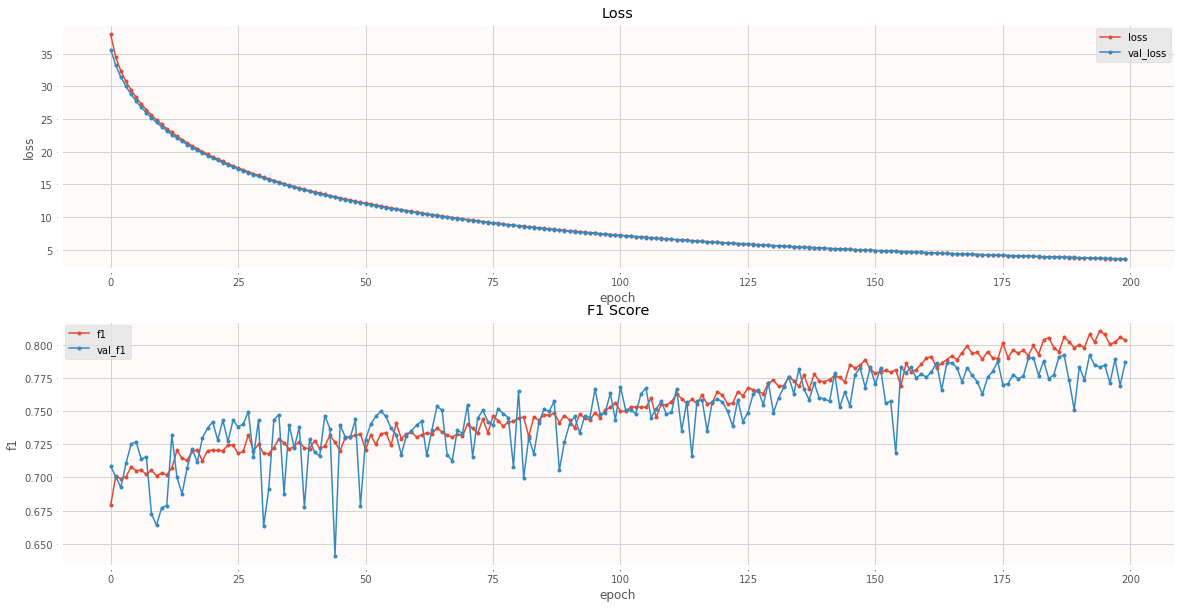

In [31]:
history, model = train_simple_rnn(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_simple_rnn(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

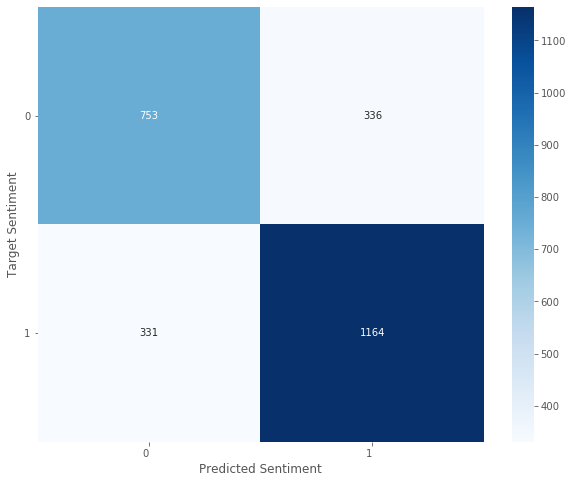

In [32]:
_, model = train_simple_rnn(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           2251500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 300)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64, 50)            17550     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51  

In [34]:
def train_gru(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    # x = Bidirectional(GRU(units=config["output_size"], return_sequences=True, dropout=config['dropout_rate']))(x)
    x = GRU(units=config["output_size"], return_sequences=True, dropout=config['dropout_rate'])(x)
    x = GRU(units=config["output_size"], return_sequences=False, dropout=config['dropout_rate'])(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    if not load_weights:
        model.compile(loss=config["loss"], 
                      optimizer=rmsprop, 
                      metrics=[get_f1])

        print("="*20, "Start Training GRU", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\gru_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\gru_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 725  204]
 [ 359 1296]]
Accuracy:  0.7821 F1:  0.8216


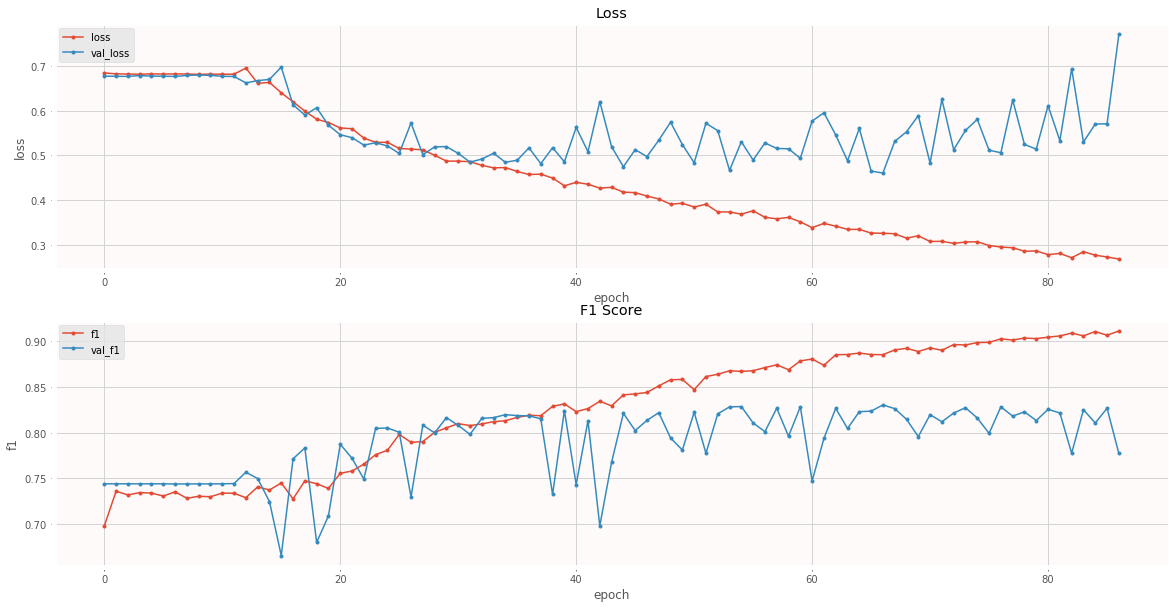

In [35]:
history, model = train_gru(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_gru(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

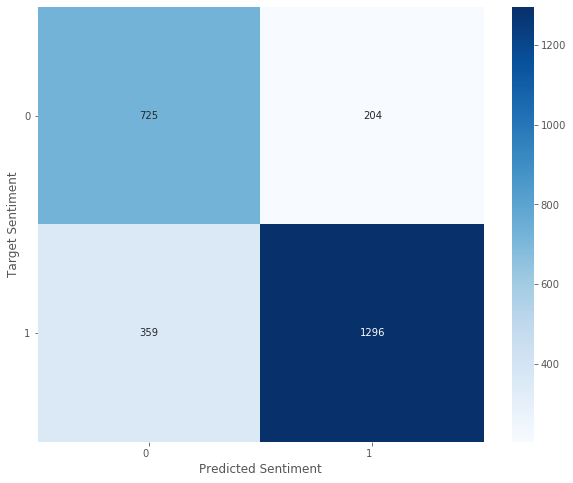

In [36]:
_, model = train_gru(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           2251500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 300)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 50)            52650     
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51  

In [25]:
def train_lstm(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=True, kernel_regularizer=regularizers.l2(0.3))(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=False, kernel_regularizer=regularizers.l2(0.3))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    if not load_weights: 
        model.compile(loss=config["loss"], 
                      optimizer=adagrad, 
                      metrics=[get_f1])

        print("="*20, "Start Training LSTM", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\lstm_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\lstm_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 839  350]
 [ 245 1150]]
Accuracy:  0.7697 F1:  0.7945


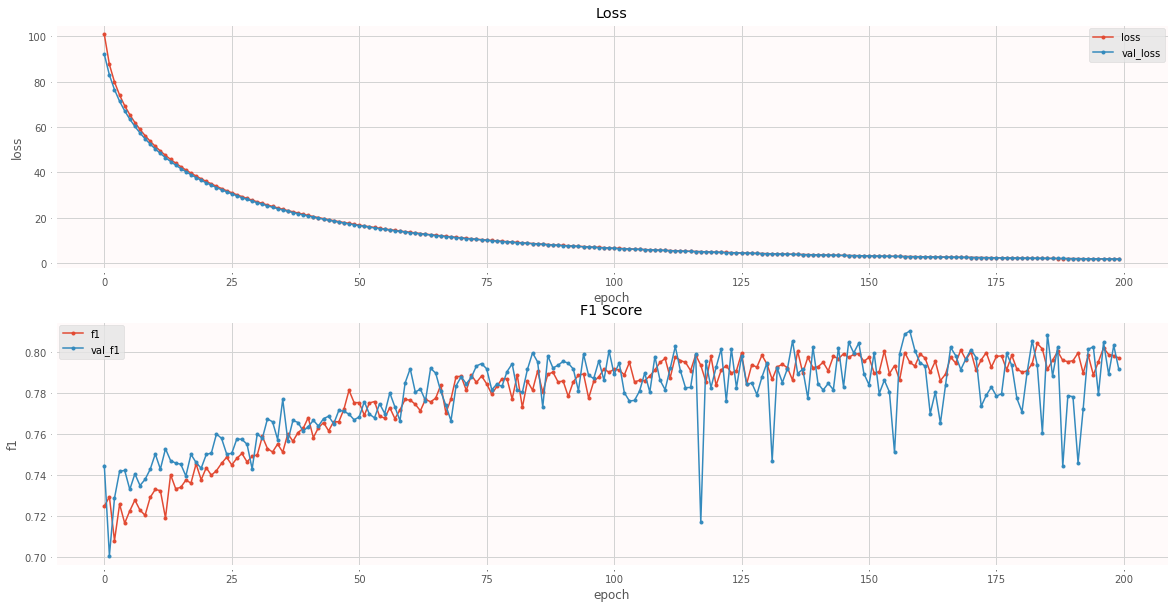

In [26]:
history, model = train_lstm(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_lstm(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

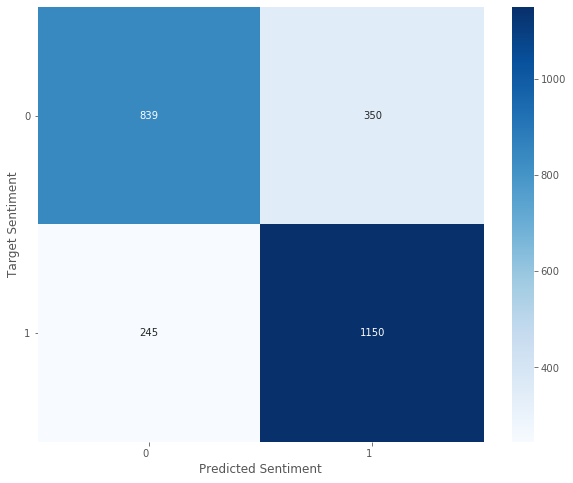

In [27]:
_, model = train_lstm(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           2251500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 64)            93440     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65  

In [29]:
def train_bilstm(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = Bidirectional(LSTM(
        units=config['lstm_cell'], 
        return_sequences=True, 
        dropout=config['dropout_rate'], 
        kernel_regularizer=regularizers.l2(0.3)))(x)
    x = Bidirectional(LSTM(
        units=config['lstm_cell'], 
        return_sequences=False, 
        kernel_regularizer=regularizers.l2(0.3)))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(config['fc_cell'])(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    if not load_weights:
        model.compile(loss=config["loss"], 
                      optimizer=adagrad, 
                      metrics=[get_f1])

        print("="*20, "Start Training BiLSTM", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\bilstm_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\weights\bilstm_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 811  391]
 [ 273 1109]]
Accuracy:  0.743 F1:  0.7696


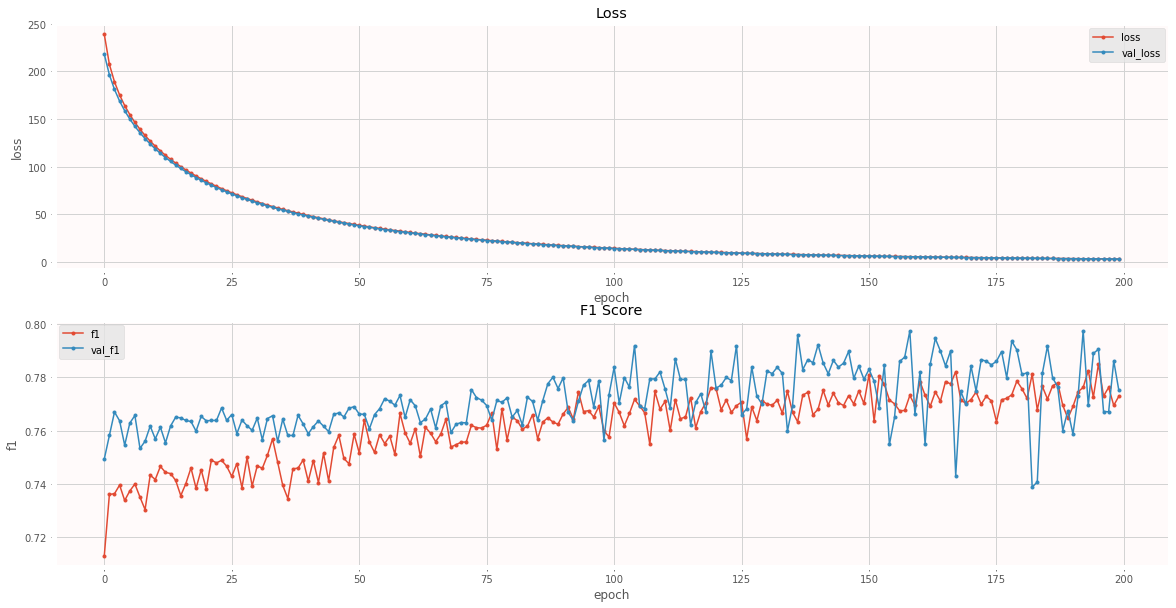

In [30]:
history, model = train_bilstm(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_bilstm(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

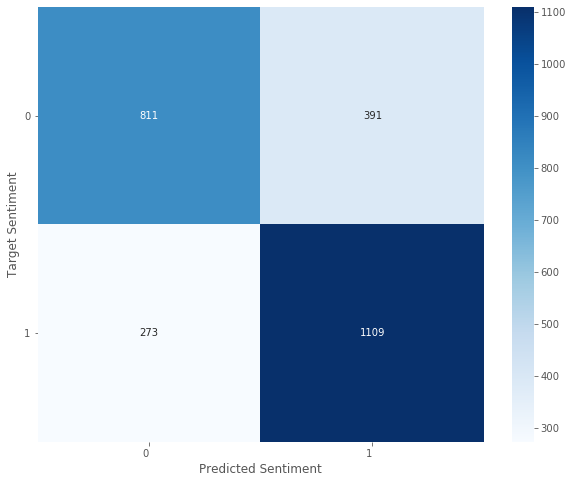

In [31]:
_, model = train_bilstm(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           2251500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           186880    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1651

In [33]:
def train_attention(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = Flatten()(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    if not load_weights:
        model.compile(loss=config["loss"], 
                      optimizer=adagrad, 
                      metrics=[get_f1])

        print("="*20, "Start Training Attention", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\attention_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001, verbose=1)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\attention_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training Attention ====================
Confusion Matrix: 
 [[ 751  314]
 [ 333 1186]]
Accuracy:  0.7496 F1:  0.7857


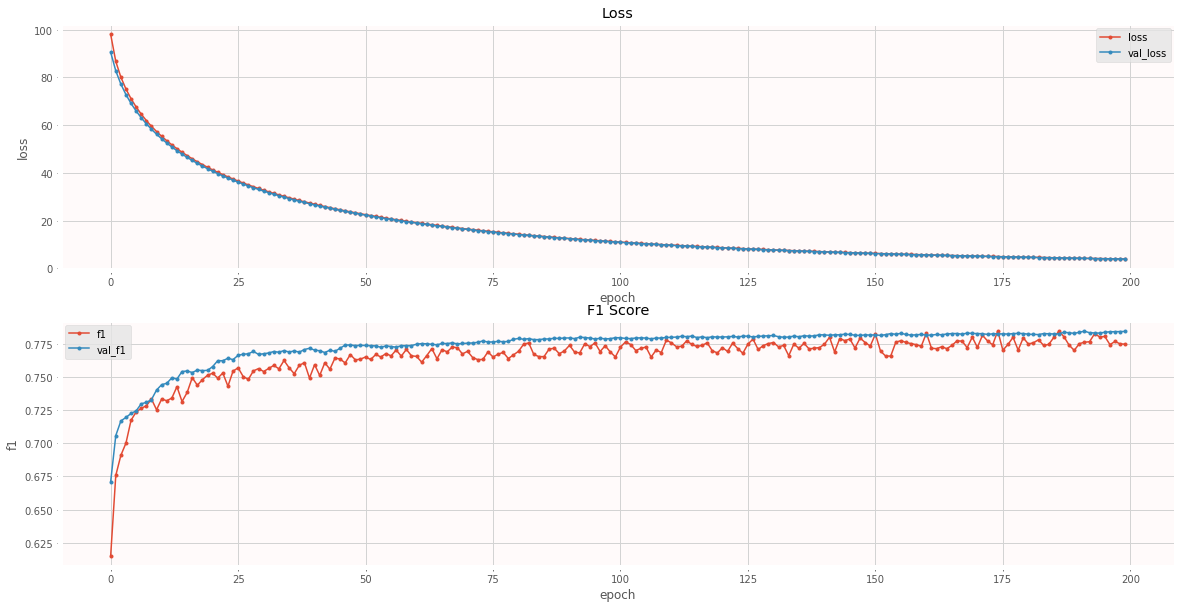

In [34]:
history, model = train_attention(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_attention(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

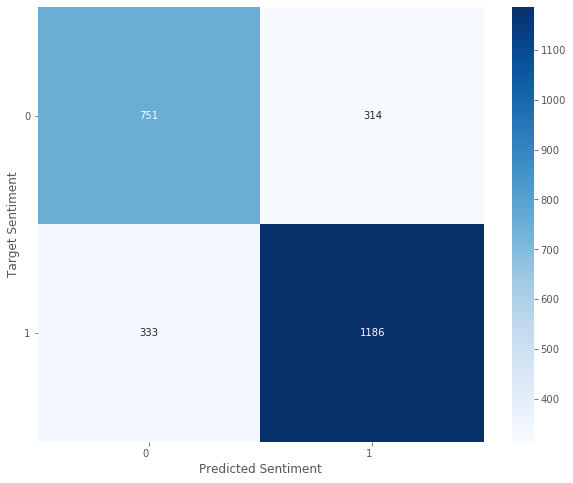

In [35]:
_, model = train_attention(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           2251500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 300)           0         
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 64, 300)           77057     
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, 64, 300)           77057     
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, 64, 300)           77057     
_________________________________________________________________
flatten_1 (Flatten)          (None, 19200)             0   

In [37]:
# Yoon Kim's paper: Convolutional Neural Networks for Sentence Classification
# Reference from https://www.aclweb.org/anthology/D14-1181.pdf
def train_cnn_static(x_train, y_train, wv_matrix, trainable=False, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=trainable)(x_input)
    
    x_conv_1 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=3, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(0.3))(x)
    x_conv_1 = BatchNormalization()(x_conv_1)
    x_conv_1 = Activation("relu")(x_conv_1)
    x_conv_1 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_1)
    
    x_conv_2 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=4, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(0.3))(x)
    x_conv_2 = BatchNormalization()(x_conv_2)
    x_conv_2 = Activation("relu")(x_conv_2)
    x_conv_2 = MaxPooling1D(pool_size=(config["MAX_LEN"]-4+1), strides=1, padding="valid")(x_conv_2)
    
    x_conv_3 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=5, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(0.3))(x)
    x_conv_3 = BatchNormalization()(x_conv_3)
    x_conv_3 = Activation("relu")(x_conv_3)
    x_conv_3 = MaxPooling1D(pool_size=(config["MAX_LEN"]-5+1), strides=1, padding="valid")(x_conv_3)
    
    main = Concatenate(axis=1)([x_conv_1, x_conv_2, x_conv_3])
    main = Flatten()(main)
    main = Dropout(config['dropout_rate'])(main)
    main = Dense(units=1)(main)
    main = Activation('sigmoid')(main)
    model = Model(inputs=x_input, outputs=main)

    if not load_weights:
        model.compile(loss=config["loss"], 
                      optimizer=adagrad, 
                      metrics=[get_f1])

        print("="*20, "Start Training CNN-static", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\cnn_static_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\cnn_static_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 806  307]
 [ 278 1193]]
Accuracy:  0.7736 F1:  0.8031


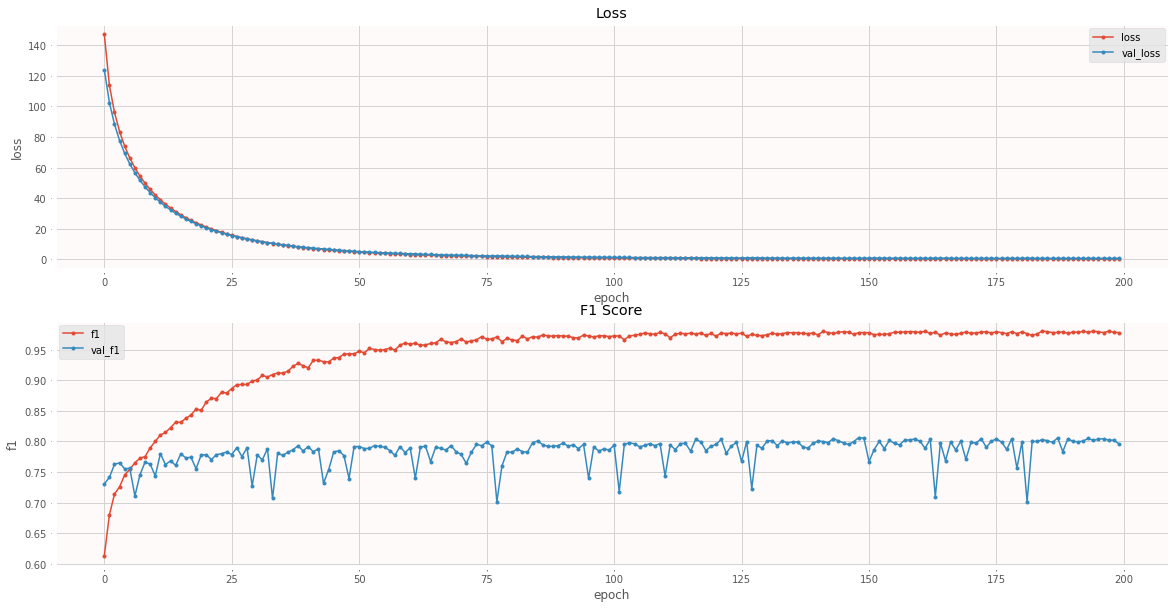

In [38]:
history, model = train_cnn_static(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_cnn_static(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

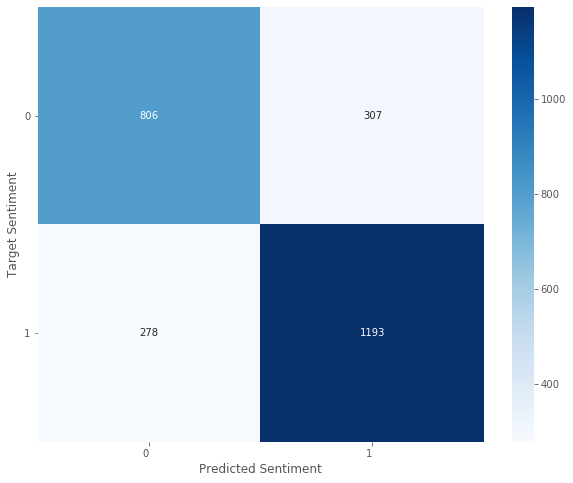

In [39]:
_, model = train_cnn_static(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 300)      2251500     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64, 150)      135150      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 64, 150)      180150      embedding_1[0][0]                
____________________________________________________________________________________________

In [41]:
def train_cnn_multichannel(x_train, y_train, wv_matrix, trainable=False, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    # Channel 1
    x_input_1 = Input(shape=(config["MAX_LEN"], ))
    embedding_1 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_1)
    x_conv_1 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(0.3))(embedding_1)
    x_conv_1 = BatchNormalization()(x_conv_1)
    x_conv_1 = Activation("relu")(x_conv_1)
    x_conv_1 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_1)
    flat_1 = Flatten()(x_conv_1)
    
    # Channel 2
    x_input_2 = Input(shape=(config["MAX_LEN"], ))
    embedding_2 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_2)
    x_conv_2 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(0.3))(embedding_2)
    x_conv_2 = BatchNormalization()(x_conv_2)
    x_conv_2 = Activation("relu")(x_conv_2)
    x_conv_2 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_2)
    flat_2 = Flatten()(x_conv_2)
    
    # Channel 1
    x_input_3 = Input(shape=(config["MAX_LEN"], ))
    embedding_3 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_3)
    x_conv_3 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(0.3))(embedding_3)
    x_conv_3 = BatchNormalization()(x_conv_3)
    x_conv_3 = Activation("relu")(x_conv_3)
    x_conv_3 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_3)
    flat_3 = Flatten()(x_conv_3)
    
    main = Concatenate(axis=1)([flat_1, flat_2, flat_3])
    main = Dense(units=100)(main)
    main = Activation('relu')(main)
    main = Dropout(config['dropout_rate'])(main)
    main = Dense(units=1)(main)
    main = Activation('sigmoid')(main)
    model = Model(inputs=[x_input_1, x_input_2, x_input_3], outputs=main)

    if not load_weights:
        model.compile(loss=config["loss"], 
                      optimizer=adagrad, 
                      metrics=[get_f1])

        print("="*20, "Start Training CNN-multichannel", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\{}_weights.hdf5'.format("cnn_multi")
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            [x_train, x_train, x_train], y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\{}_weights.hdf5'.format("cnn_multi")
        model.load_weights(path)
    
    return history, model

==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 780  279]
 [ 304 1221]]
Accuracy:  0.7744 F1:  0.8073


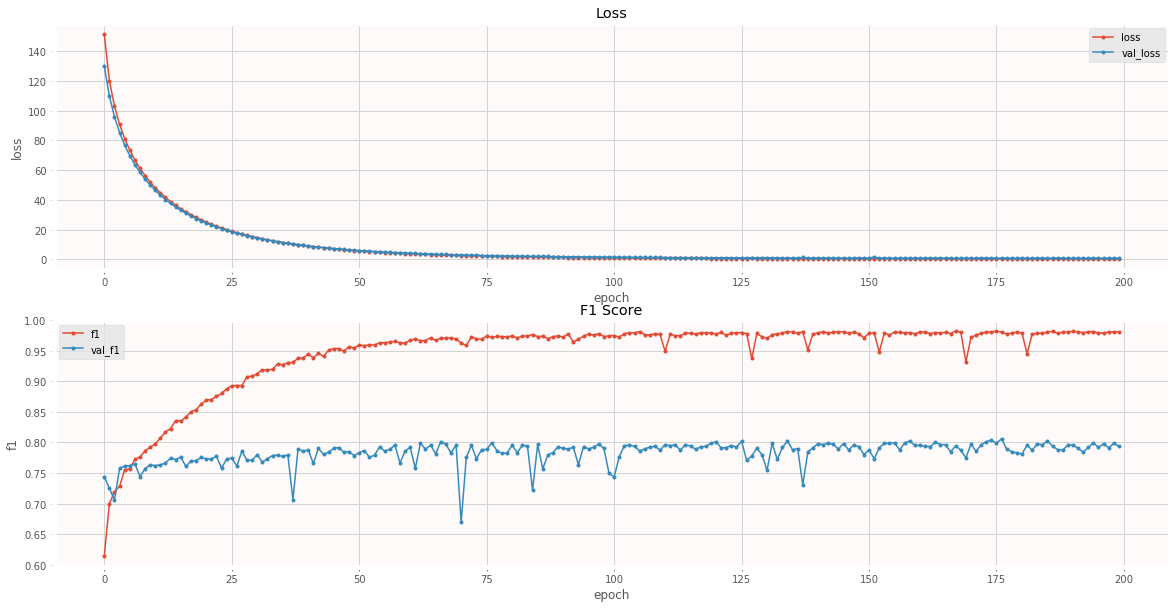

In [42]:
history, model = train_cnn_multichannel(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_cnn_multichannel(x_train, y_train, embedding_matrix, load_weights=True)
y_prob = model.predict([x_test, x_test, x_test])
y_prob = y_prob.squeeze()
y_pred = (y_prob > 0.5)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

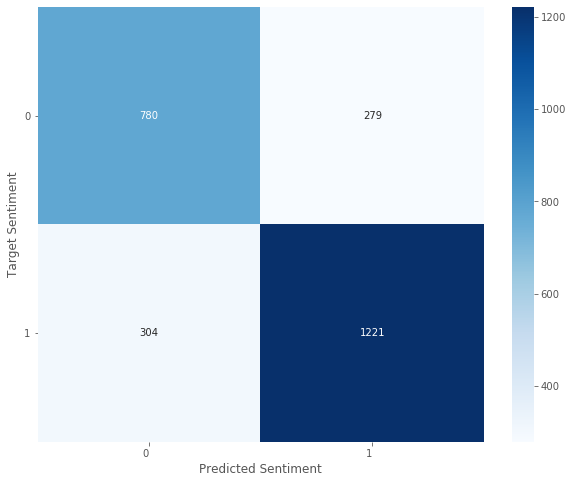

In [43]:
_, model = train_cnn_multichannel(x_train, y_train, embedding_matrix, load_weights=True)
y_prob = model.predict([x_test, x_test, x_test])
y_prob = y_prob.squeeze()
y_pred = (y_prob > 0.5)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 300)      2251500     input_1[0][0]                    
____________________________________________________________________________________________

In [45]:
def train_cnn_lstm(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    
    x = Conv1D(filters=config['nb_filter'], kernel_size=config['filter_length'], padding=config['border_mode'])(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=config['pool_length'])(x)
    
    x = Conv1D(filters=config['nb_filter']*2, kernel_size=config['filter_length'], padding=config['border_mode'])(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=config['pool_length'])(x)
    
    x = Conv1D(filters=config['nb_filter']*4, kernel_size=config['filter_length'], padding=config['border_mode'])(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=config['pool_length'])(x)
    
    x = LSTM(units=config['lstm_cell'], return_sequences=True, kernel_regularizer=regularizers.l2(0.3))(x)
    x = SeqSelfAttention(units=config['lstm_cell'], kernel_regularizer=regularizers.l2(0.1))(x)
    
    x = Flatten()(x)
    x = Dense(config['fc_cell'])(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    if not load_weights:
        model.compile(loss=config['loss'], 
                      optimizer=adadelta, 
                      metrics=[get_f1])

        print("="*20, "Start Training CNN-LSTM", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\{}_weights.hdf5'.format("cnn_lstm")
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config['batch_size'], 
            epochs=config['nb_epoch'], 
            validation_split=config['validation_split'], 
            shuffle=config['shuffle'], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights: 
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\{}_weights.hdf5'.format("cnn_lstm")
        model.load_weights(path)
    
    return history, model

==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 717  310]
 [ 367 1190]]
Accuracy:  0.738 F1:  0.7785


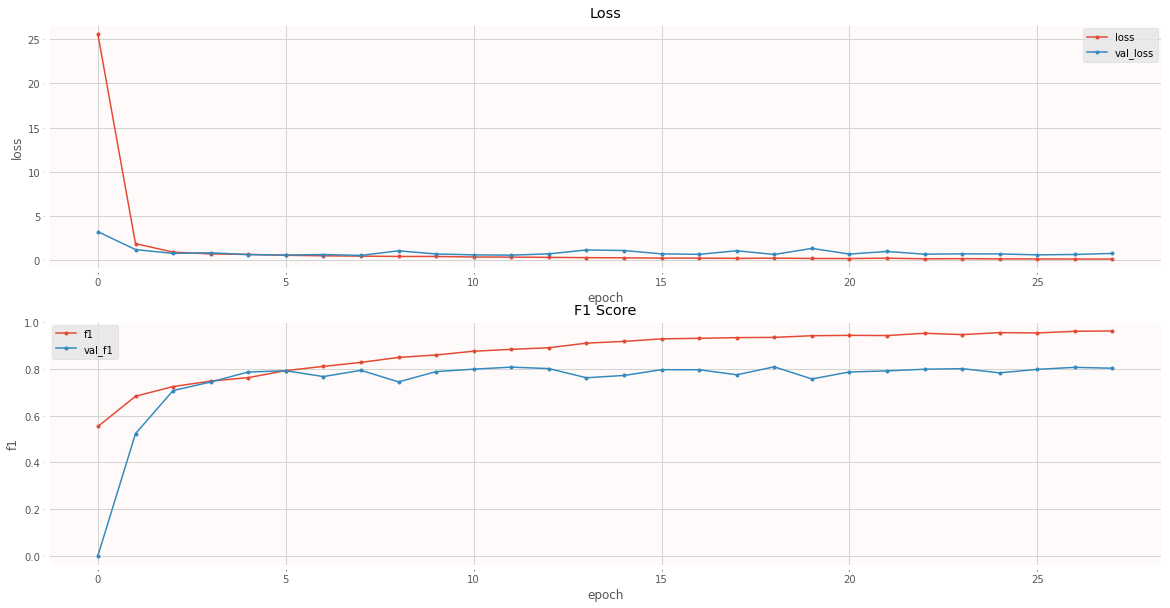

In [46]:
history, model = train_cnn_lstm(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_cnn_lstm(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

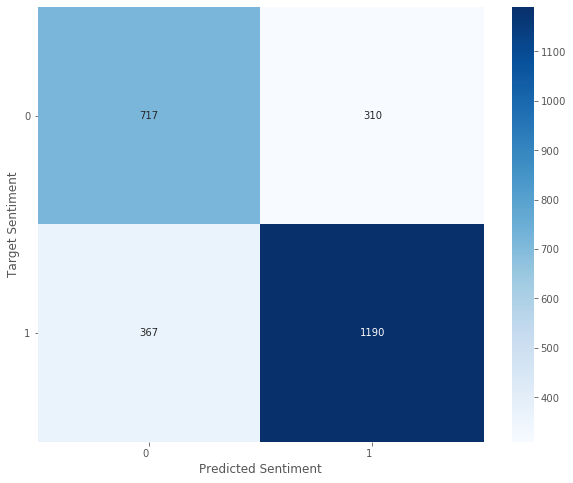

In [47]:
_, model = train_cnn_lstm(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [48]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           2251500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 150)           135150    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 150)           600       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 150)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 150)           0   

In [57]:
def identity_resnet_block(x, nb_filter):
    x_shortcut = x

    # First component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Second component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(res_x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Third component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(res_x)
    res_x = BatchNormalization()(res_x)

    # Final Step: add shortcut value to the main path
    x = Add()([x_shortcut, res_x])
    output = Activation('relu')(x)
    return output

def convolutional_resnet_block(x, nb_filter):
    x_shortcut = x

    # First component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Second component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(res_x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Third component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(res_x)
    res_x = BatchNormalization()(res_x)

    # Shortcut path
    x_shortcut = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    # Final Step: add shortcut value to the main path
    x = Add()([x_shortcut, res_x])
    output = Activation('relu')(x)
    return output

def train_text_resnet(x_train, y_train, wv_matrix, verbose=0, load_weights=False):
    tf.keras.backend.clear_session()
    # Resnet for reviews of UtaPass and KKBOX
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(0.25)(x)

    # Stage 1
    x = Conv1D(filters=64, kernel_size=3, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    # Stage 2
    x = convolutional_resnet_block(x, 64)
    x = identity_resnet_block(x, 64)
    x = identity_resnet_block(x, 64)
    # Stage 3
    x = convolutional_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    # Stage 4
    x = convolutional_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    # Stage 5
    x = convolutional_resnet_block(x, 512)
    x = identity_resnet_block(x, 512)
    x = identity_resnet_block(x, 512)
    # Average pool
    x = AveragePooling1D(pool_size = 1)(x)
    # Output layer
    x = Flatten()(x)

    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=1)(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=x_input, outputs=x)
    
    if not load_weights: 
        model.compile(loss=config["loss"],
                      optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0),
                      metrics=[get_f1])

        print("="*20, "Start Training Text-ResNet", "="*20)

        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\text_resnet_weights.hdf5'
        model_checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

        history = model.fit(
            x_train, y_train, 
            batch_size=config["batch_size"], 
            epochs=config["nb_epoch"], 
            validation_split=config["validation_split"], 
            shuffle=config["shuffle"], 
            verbose=verbose, 
            callbacks=[early_stopping, reduce_lr, model_checkpoint])
    if load_weights:
        history = None
        path = r'C:\Users\YangWang\Desktop\UtaPass_KKBOX_Classifier\weights\text_resnet_weights.hdf5'
        model.load_weights(path)
    
    return history, model

==================== Start Training Text-ResNet ====================
Confusion Matrix: 
 [[ 809  427]
 [ 275 1073]]
Accuracy:  0.7283 F1:  0.7535


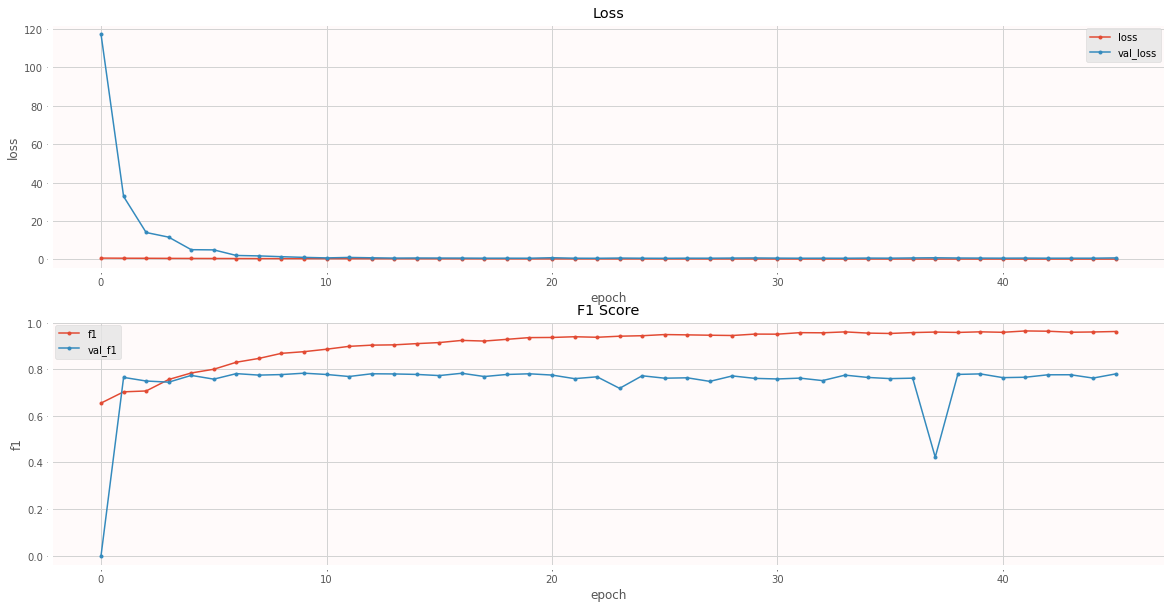

In [58]:
history, model = train_text_resnet(x_train, y_train, embedding_matrix, load_weights=False)
_, model = train_text_resnet(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
acc_score = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
print("Accuracy: ", round(acc_score, 4), "F1: ", round(f1, 4))

plot_history(history)

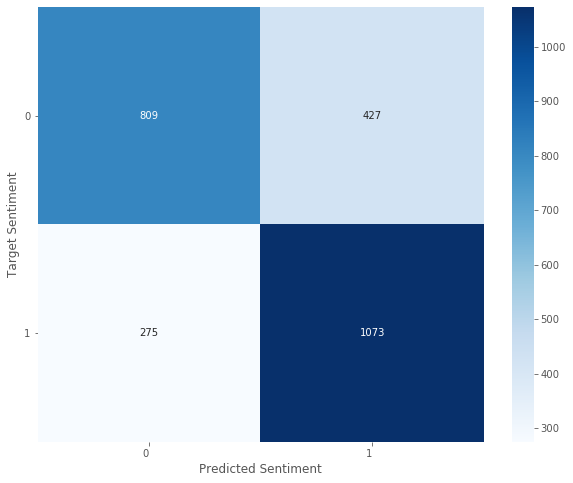

In [59]:
_, model = train_text_resnet(x_train, y_train, embedding_matrix, load_weights=True)
y_pred = predict(x_test, model)
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm)

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 300)      2251500     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 64, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 31, 64)       57664       spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [53]:
# plt.savefig(r'C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\image\cumulative_percentage.png', 
#             bbox_inches='tight')